In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ML Models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Parallel
from joblib import Parallel, delayed
import time
import random

In [3]:
df = pd.read_csv('/content/ca_daily_fire_2000_2021-v2.csv')

In [4]:
df.head()

,latitude,longitude,acq_date,satellite,instrument,frp,type,bright_t31,confidence,year,month
0,32.4646,-114.6906,2011-06-29,Terra,MODIS,91.1,0,315.7,84,2011,6
1,32.4768,-114.6785,2011-10-11,Terra,MODIS,96.2,0,313.7,100,2011,10
2,32.4937,-114.7856,2013-02-06,Terra,MODIS,26.9,0,296.1,65,2013,2
3,32.4987,-114.7985,2010-02-04,Terra,MODIS,22.2,0,282.9,62,2010,2
4,32.5006,-114.7929,2009-07-08,Aqua,MODIS,172.0,0,316.4,78,2009,7


In [5]:
df.shape

(221183, 11)

In [6]:
df.isnull().sum()

,0
latitude,0
longitude,0
acq_date,0
satellite,0
instrument,0
frp,0
type,0
bright_t31,0
confidence,0
year,0


In [7]:
# Drop rows with missing values in required columns
cols = ['latitude', 'longitude', 'frp', 'confidence', 'bright_t31', 'month', 'year']
df = df.dropna(subset=cols)

# Feature set and targets
X = df[['latitude', 'longitude', 'frp', 'confidence', 'month', 'year']]
y = df['bright_t31']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221183 entries, 0 to 221182
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    221183 non-null  float64
 1   longitude   221183 non-null  float64
 2   acq_date    221183 non-null  object 
 3   satellite   221183 non-null  object 
 4   instrument  221183 non-null  object 
 5   frp         221183 non-null  float64
 6   type        221183 non-null  int64  
 7   bright_t31  221183 non-null  float64
 8   confidence  221183 non-null  int64  
 9   year        221183 non-null  int64  
 10  month       221183 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 18.6+ MB


In [9]:
df.describe() # descriptive stats

,latitude,longitude,frp,type,bright_t31,confidence,year,month
count,221183.000000,221183.000000,221183.000000,221183.000000,221183.000000,221183.000000,221183.000000,221183.000000
mean,38.218017,-120.263418,137.750609,0.010991,299.375297,83.162490,2012.581812,7.933978
std,2.536727,2.395738,353.842116,0.150897,12.301854,16.044658,6.056995,2.117886
min,32.464600,-123.999700,0.000000,0.000000,265.300000,50.000000,2000.000000,1.000000
25%,36.280050,-122.345450,19.900000,0.000000,291.500000,70.000000,2007.000000,7.000000
50%,38.660300,-120.495900,43.100000,0.000000,297.600000,86.000000,2013.000000,8.000000
75%,40.319500,-118.776300,110.100000,0.000000,305.600000,100.000000,2018.000000,9.000000
max,41.999900,-114.000100,11944.200000,3.000000,400.100000,100.000000,2020.000000,12.000000


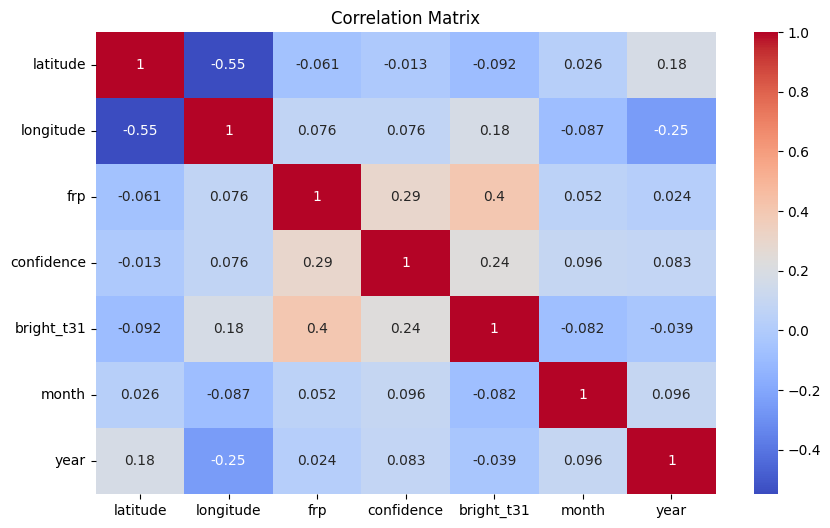

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

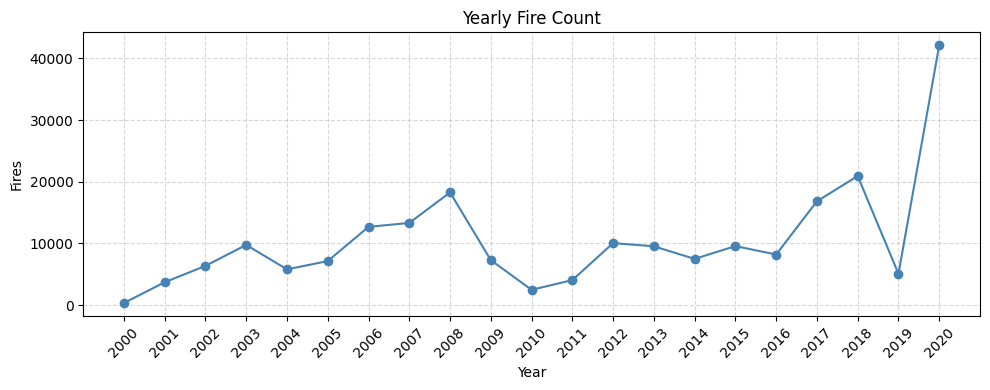

In [37]:
# Convert year to int for clean labels
df['year'] = df['year'].astype(int)

# Count fires per year
fires_per_year = df['year'].value_counts().sort_index()

# Fires per year
plt.figure(figsize=(10, 4))
df['year'].value_counts().sort_index().plot(kind='line', marker='o', color='steelblue')
plt.title("Yearly Fire Count")
plt.xlabel("Year")
plt.ylabel("Fires")
plt.xticks(ticks=fires_per_year.index, rotation=45)  # Force exact year labels
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [38]:
# Create severity class (target): 0 = Low, 1 = Moderate, 2 = Severe
def map_severity(brightness):
    if brightness >= 450: return 2
    elif brightness >= 300: return 1
    return 0

df['severity'] = df['bright_t31'].apply(map_severity)

In [12]:
df.head()

,latitude,longitude,acq_date,satellite,instrument,frp,type,bright_t31,confidence,year,month,severity
0,32.4646,-114.6906,2011-06-29,Terra,MODIS,91.1,0,315.7,84,2011,6,1
1,32.4768,-114.6785,2011-10-11,Terra,MODIS,96.2,0,313.7,100,2011,10,1
2,32.4937,-114.7856,2013-02-06,Terra,MODIS,26.9,0,296.1,65,2013,2,0
3,32.4987,-114.7985,2010-02-04,Terra,MODIS,22.2,0,282.9,62,2010,2,0
4,32.5006,-114.7929,2009-07-08,Aqua,MODIS,172.0,0,316.4,78,2009,7,1


In [24]:
# Define all expected severity classes
expected_classes = [0, 1, 2]

# Count severity classes
severity_counts = df['severity'].value_counts().sort_index()
severity_counts = severity_counts.reindex(expected_classes, fill_value=0)

# Print counts
print("Severity Class Counts:")
for severity_class, count in severity_counts.items():
    label = {0: "Low", 1: "Moderate", 2: "Severe"}.get(severity_class, "Unknown")
    print(f"Class {severity_class} ({label}): {count} instances")

Severity Class Counts:
Class 0 (Low): 128623 instances
Class 1 (Moderate): 92560 instances
Class 2 (Severe): 0 instances


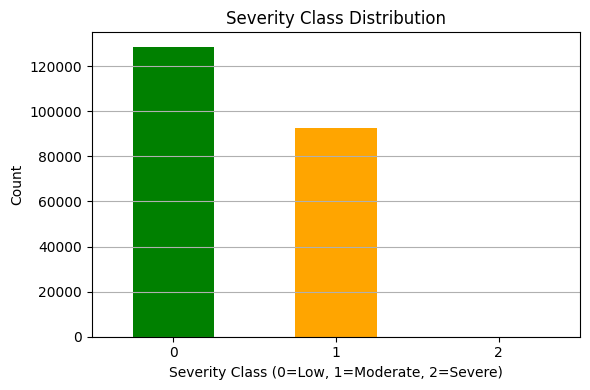

In [25]:
# Plot bar chart for severity
plt.figure(figsize=(6, 4))
severity_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Severity Class Distribution")
plt.xlabel("Severity Class (0=Low, 1=Moderate, 2=Severe)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [27]:
# Update y for classification
y_cls = df['severity']
X_cls = df[['latitude', 'longitude', 'frp', 'confidence', 'month', 'year']]

# Train-test split for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Total length of training and testing
print("Train size:", len(X_train_c))
print("Test size:", len(X_test_c))

Train size: 176946
Test size: 44237


=== Decision Tree Classifier ===

 Accuracy: 0.6891742206750006

 Confusion Matrix:



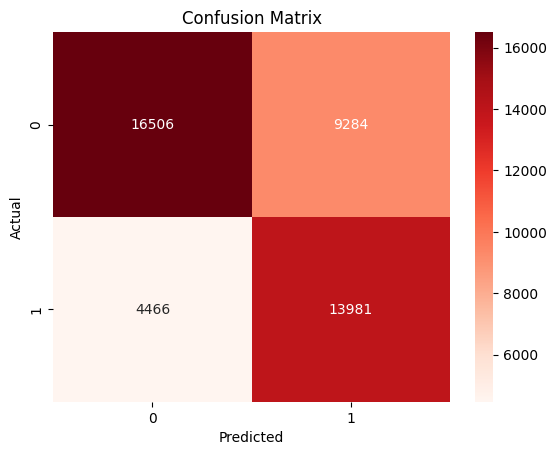


 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.64      0.71     25790
           1       0.60      0.76      0.67     18447

    accuracy                           0.69     44237
   macro avg       0.69      0.70      0.69     44237
weighted avg       0.71      0.69      0.69     44237



In [14]:
# Train Decision Tree Classifier
clf_dt = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_dt.fit(X_train_c, y_train_c)

# Predict and evaluate
y_pred_dt = clf_dt.predict(X_test_c)

print("=== Decision Tree Classifier ===")

# Accuracy
print("\n Accuracy:", accuracy_score(y_test_c, y_pred_dt))

# Confusion matrix
print("\n Confusion Matrix:\n")

cm = confusion_matrix(y_test_c, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\n Classification Report:\n", classification_report(y_test_c, y_pred_dt))


=== Random Forest Classifier ===

 Accuracy: 0.7986301060198476

 Confusion Matrix:



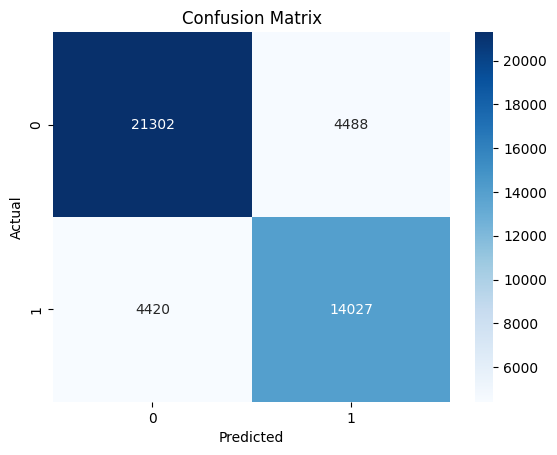


 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     25790
           1       0.76      0.76      0.76     18447

    accuracy                           0.80     44237
   macro avg       0.79      0.79      0.79     44237
weighted avg       0.80      0.80      0.80     44237



In [15]:
# Train Random Forest Classifier
rf_cls = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_cls.fit(X_train_c, y_train_c)

# Predict and evaluate
y_pred_c = rf_cls.predict(X_test_c)

print("=== Random Forest Classifier ===")

# Accuracy
print("\n Accuracy:", accuracy_score(y_test_c, y_pred_c))

# Confusion matrix
print("\n Confusion Matrix:\n")
cm = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\n Classification Report:\n", classification_report(y_test_c, y_pred_c))


In [16]:
# Generate random training type
def check_training_type():
    return random.choice(["Parallel Training", "Sequential Training"])
print("Training Type:", check_training_type())

Training Type: Sequential Training


In [17]:
# Compare Serial vs Parallel Training Time
# Serial Training
start_time_serial = time.time()
model_serial = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
model_serial.fit(X_train_c, y_train_c)
y_pred_serial = model_serial.predict(X_test_c)
serial_time = time.time() - start_time_serial

# Parallel Training
start_time_parallel = time.time()
model_parallel = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
model_parallel.fit(X_train_c, y_train_c)
y_pred_parallel = model_parallel.predict(X_test_c)
parallel_time = time.time() - start_time_parallel

Serial Training Time: 64.24 sec
Parallel Training Time: 42.71 sec

Serial Accuracy: 0.7986
Parallel Accuracy: 0.7986

=== Confusion Matrix (Serial) ===


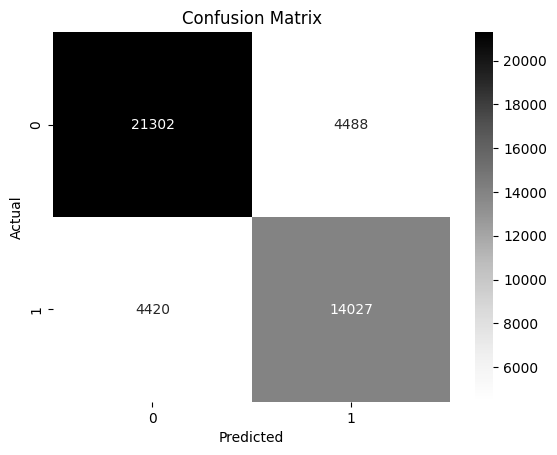


=== Confusion Matrix (Parallel) ===


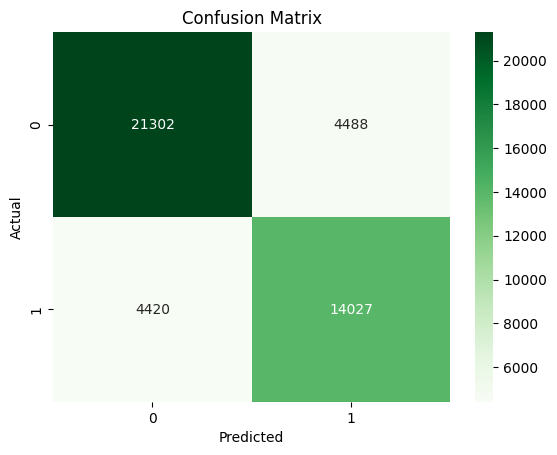


=== Classification Report (Serial) ===
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     25790
           1       0.76      0.76      0.76     18447

    accuracy                           0.80     44237
   macro avg       0.79      0.79      0.79     44237
weighted avg       0.80      0.80      0.80     44237


=== Classification Report (Parallel) ===
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     25790
           1       0.76      0.76      0.76     18447

    accuracy                           0.80     44237
   macro avg       0.79      0.79      0.79     44237
weighted avg       0.80      0.80      0.80     44237



In [18]:
# Evaluate Serial vs Parallel Training
acc_serial = accuracy_score(y_test_c, y_pred_serial)
acc_parallel = accuracy_score(y_test_c, y_pred_parallel)

print("Serial Training Time:", round(serial_time, 2), "sec")
print("Parallel Training Time:", round(parallel_time, 2), "sec")

print("\nSerial Accuracy:", round(acc_serial, 4))
print("Parallel Accuracy:", round(acc_parallel, 4))

print("\n=== Confusion Matrix (Serial) ===")
cm = confusion_matrix(y_test_c, y_pred_serial)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Confusion Matrix (Parallel) ===")
cm = confusion_matrix(y_test_c, y_pred_parallel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Classification Report (Serial) ===")
print(classification_report(y_test_c, y_pred_serial))

print("\n=== Classification Report (Parallel) ===")
print(classification_report(y_test_c, y_pred_parallel))

In [19]:
# Compare accuracy and speed
print("== Accuracy Comparison ==")
print("Serial vs Parallel:", round(acc_serial, 4), "vs", round(acc_parallel, 4))

print("\n== Speed Comparison ==")
print("Serial vs Parallel:", round(serial_time, 4), "vs", round(parallel_time, 4))

print("\nTraining Type Check:", check_training_type())

== Accuracy Comparison ==
Serial vs Parallel: 0.7986 vs 0.7986

== Speed Comparison ==
Serial vs Parallel: 64.2354 vs 42.714

Training Type Check: Sequential Training


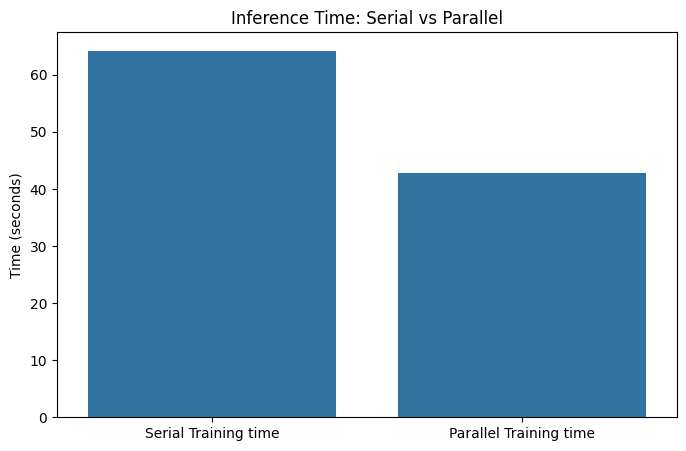

In [26]:
# Plot comparison of training/inference time
times = [serial_time, parallel_time]
labels = ['Serial Training time', 'Parallel Training time']

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=times)
plt.ylabel("Time (seconds)")
plt.title("Inference Time: Serial vs Parallel")
plt.show()

In [20]:
# Parallel preprocessing Time
def row_process(row):
    return row['latitude'] + row['longitude'] + row['frp']

start = time.time()
_ = Parallel(n_jobs=-1)(delayed(row_process)(row) for _, row in df.iterrows())
end = time.time()

print("Parallel Preprocessing Time:", round(end - start, 2), "sec")


Parallel Preprocessing Time: 63.69 sec
